In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plotLine(x1,y1,x2,y2):
    plt.gca().plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=0.6)

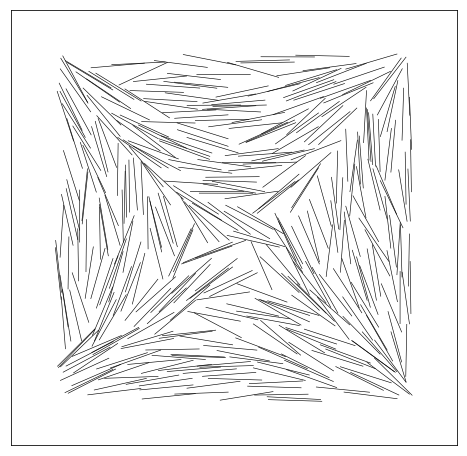

In [45]:
w = 25.
h = w
plt.plot()
plt.xlim(-w/2,w/2)
plt.ylim(-h/2,h/2)
plt.xticks([])
plt.yticks([])

# Read in data
fname = "output/test_X"
# fname = "save/confX/sweep_00085000"
dfile = open(fname, "r")
cntSnap = 0
showSnap = 10
for line in dfile.readlines():
    if showSnap == cntSnap:
        if line == "\n": break
        l = line.split()
        plotLine(l[5],l[6],l[7],l[8])
    else: 
        if line == "\n": cntSnap+=1
        else: continue
l[4]
plt.gcf().set_size_inches(8,8)
f = plt.gcf()


In [4]:
f.savefig(fname+".eps");